# Lendo dados experimentais


   vazao    h1    h2
0    0.0 -0.47 -0.06
1    0.0 -0.57 -0.06
2    0.0 -0.57 -0.16
3    0.0 -0.07 -0.16
4    0.0 -0.47 -0.06


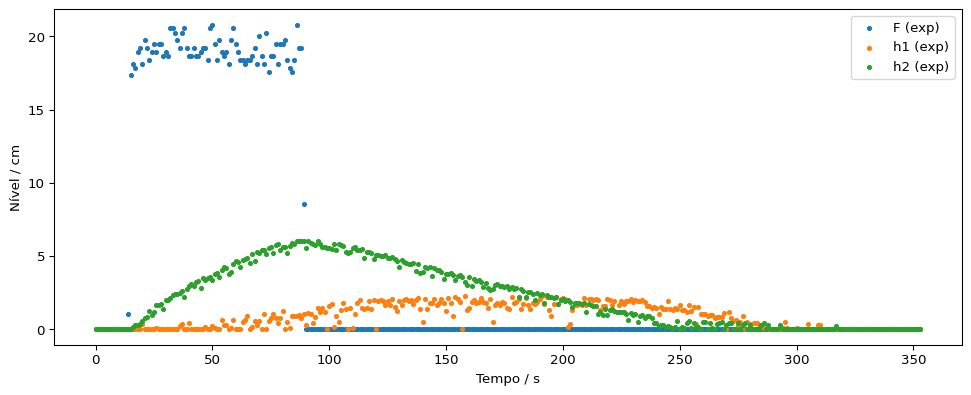

In [1]:
import numpy as np
import pandas as pd

from plot import plot_tanks

exp_data = pd.read_csv("../dados.csv")

F_exp = exp_data["vazao"].to_numpy() * 2
h1_exp = np.clip(exp_data["h1"].to_numpy(), 0.0, None)
h2_exp = np.clip(exp_data["h2"].to_numpy(), 0.0, None)
t = np.arange(len(F_exp))

print(exp_data.head())

plot_tanks(t, [F_exp, h1_exp, h2_exp], ["F (exp)", "h1 (exp)", "h2 (exp)"], scatter=3)


# Definindo sistema


In [2]:
import numpy as np
from scipy.integrate import solve_ivp

from typings import Bounds


def F(t: float | int):
    return F_exp[int(t)]


def edo(t, Y, cv1, cv2):
    # Constantes
    a2 = 10 * 15  # cm^2
    a1 = np.pi * (11 / 2) ** 2  # cm^2
    # a2 = 160.0
    # a1 = 95.03

    # Dependent variables
    h2, h1 = Y[0], Y[1]

    # Tanks limits
    h2 = np.where(h2 < 0.0, 0.0, h2)
    h1 = np.where(h1 < 0.0, 0.0, h1)

    # Equations
    dh2dt = (F(t) / a2) - ((cv2 * np.sqrt(h2)) / a2)
    dh1dt = ((cv2 * np.sqrt(h2)) / a1) - ((cv1 * np.sqrt(h1)) / a1)
    return [dh2dt, dh1dt]


def simulate(c1, c2):
    sol = solve_ivp(
        edo,
        [t[0], t[-1]],
        [h1_exp[0], h2_exp[0]],
        t_eval=t,
        method="RK45",
        args=(c1, c2),
    )
    return sol.y


bounds: Bounds = [(0, 8), (0, 8)]  # Limites para Cv1 e Cv2


# Definindo função objetivo


In [3]:
import concurrent.futures
import os

import hickle as hkl


def loss(C):
    c1, c2 = C
    h2_sim, h1_sim = simulate(c1, c2)
    total_loss = np.mean(np.square(h1_exp - h1_sim)) + np.mean(
        np.square(h2_exp - h2_sim)
    )

    # print(f"c1: {c1}, c2: {c2}, loss: {total_loss}")
    return total_loss


# Visualizando a função objetivo
c1_vals = np.linspace(bounds[0][0], bounds[0][1], 200)  # Intervalo de valores para c1
c2_vals = np.linspace(bounds[1][0], bounds[1][1], 200)  # Intervalo de valores para c2
C1, C2 = np.meshgrid(c1_vals, c2_vals)


# Tentarei salvar o resultado em um arquivo, e assim só será necessário calcular uma vez
# Para forçar recalculo, basta excluir o arquivo abaixo
Z_file = "Z.hkl"

if os.path.isfile(Z_file):
    print("Recuperando cálculo anterior")
    Z = hkl.load(Z_file)
else:
    print("Não foi possível recuperar cálculo anterior. Recalculando...")
    combinations = [
        (C1[i, j], C2[i, j]) for i in range(C1.shape[0]) for j in range(C1.shape[1])
    ]
    Z = np.zeros_like(C1)

    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = list(executor.map(loss, combinations))

    for idx, result in enumerate(results):
        i, j = divmod(idx, C1.shape[1])
        Z[i, j] = result

    print("Cálculos feitos. Salvando para próximas execuções")
    hkl.dump(Z, Z_file)


Recuperando cálculo anterior


In [4]:
from plot import plot_space, plot_space_3d

# Plotando o gráfico
plot_space(C1, C2, Z, "objetive_function.png")
plot_space_3d(C1, C2, Z, "objetive_function-3d.png")


# Implementação do algorítimo genético clássico


In [5]:
from genetic_utils import crossover, initialize_population, mutate, tournament_selection
from plot import plot_population
from typings import GA_params, Population

# Fixando seed
np.random.seed(0)


# Função de avaliação do fitness (quanto menor o valor da função, melhor)
def fitness(individual):
    x, y = individual
    return -loss([x, y])  # Negativo porque estamos minimizando


# Algoritmo Genético
def genetic_algorithm(params: GA_params, fitness_func):
    # Inicializar a população
    population = initialize_population(params, fitness_func)
    plot_population(C1, C2, Z, population, "generations/00.png")
    best_individual = max(population, key=lambda ind: ind["fitness"])

    for generation in range(params["num_generations"]):
        new_population: Population = []

        while len(new_population) < params["pop_size"]:
            # Selecionar pais
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)

            # Realizar crossover
            child1, child2 = crossover(parent1, parent2, fitness_func, params)

            # Realizar mutação
            child1 = mutate(child1, fitness_func, params)
            child2 = mutate(child2, fitness_func, params)

            # Adicionar filhos à nova população
            new_population.append(child1)
            if len(new_population) < params["pop_size"]:
                new_population.append(child2)

        population = new_population
        best_new_individual = max(population, key=lambda ind: ind["fitness"])
        if best_individual["fitness"] < best_new_individual["fitness"]:
            best_individual = best_new_individual

        # Você pode gerar uma animação com as gerações usando o ffmpeg dentro da pasta generations
        # ffmpeg -f image2 -r 2 -pattern_type glob -i '*.png' -vcodec libx264 -crf 10 animation.mp4
        plot_population(
            C1, C2, Z, population, f"generations/{(generation + 1):02d}.png"
        )
        print(
            f"Geração {generation + 1}: Melhor solução = {best_individual['chromosome']}, Melhor fitness = {-best_individual['fitness']}"
        )

    return best_individual


# Definir os parâmetros do algoritmo
genetic_alg_params: GA_params = {
    "pop_size": 50,
    "num_generations": 25,
    "bounds": bounds,
    "mutation_rate": 0.1,
    "mutation_strength": 0.1,
    "crossover_rate": 0.8,
}

# Executar o algoritmo genético
best_individual = genetic_algorithm(genetic_alg_params, fitness)

print(f"Melhor solução encontrada: {best_individual["chromosome"]}")
print(f"Valor da função objetivo na melhor solução: {-best_individual['fitness']}")


Geração 1: Melhor solução = [4.768091  3.0435805], Melhor fitness = 0.3910881265355674
Geração 2: Melhor solução = [4.7482033 3.1281362], Melhor fitness = 0.34958381631394086
Geração 3: Melhor solução = [4.7482033 3.1281362], Melhor fitness = 0.34958381631394086
Geração 4: Melhor solução = [4.611538  3.1589618], Melhor fitness = 0.34621621587320556
Geração 5: Melhor solução = [4.611538  3.1589618], Melhor fitness = 0.34621621587320556
Geração 6: Melhor solução = [4.692281  3.1319137], Melhor fitness = 0.3458747991644033
Geração 7: Melhor solução = [4.721717  3.1581066], Melhor fitness = 0.34569669617510074
Geração 8: Melhor solução = [4.7150836 3.1535256], Melhor fitness = 0.34501073747006916
Geração 9: Melhor solução = [4.7150836 3.1535256], Melhor fitness = 0.34501073747006916
Geração 10: Melhor solução = [4.7150836 3.1535256], Melhor fitness = 0.34501073747006916
Geração 11: Melhor solução = [4.7150836 3.1535256], Melhor fitness = 0.34501073747006916
Geração 12: Melhor solução = [4.

In [6]:
cv1_salomão = 3.582
cv2_salomão = 2.869

h2_opt, h1_opt = simulate(
    best_individual["chromosome"][0], best_individual["chromosome"][1]
)
h2_chute, h1_chute = simulate(0.5, 7)
# h2_opt, h1_opt = simulate(cv1_salomão, cv2_salomão)

plot_tanks(
    t,
    [h1_exp, h2_exp, h1_opt, h2_opt],
    [
        "h1 (dados experimentais)",
        "h2 (dados experimentais)",
        "h1 (simulação após otimização)",
        "h2 (simulação após otimização)",
    ],
    "tanks_opt.png",
    scatter=2,
)

plot_tanks(
    t,
    [h1_exp, h2_exp, h1_chute, h2_chute],
    [
        "h1 (dados experimentais)",
        "h2 (dados experimentais)",
        "h1 (simulação antes da otimização)",
        "h2 (simulação antes da otimização)",
    ],
    "tanks_chute.png",
    scatter=2,
)
